In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import string
import nltk
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Get dataset

In [7]:
%%capture
!pip install datasets

In [8]:
%%capture
from datasets import load_dataset
dataset = load_dataset('imdb', split='train')

### Dataset preprocessing

In [9]:
# turn a doc into clean tokens
def clean_doc(doc):
	# replace '--' with a space ' '
	doc = doc.replace('--', ' ')
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# make lower case
	tokens = [word.lower() for word in tokens]
	return tokens

In [10]:
clean_dataset = [clean_doc(d) for d in dataset['text']]

### Word embedding

In [12]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as api

In [17]:
"""embedding_model = Word2Vec(size=25, min_count=1)
embedding_model.build_vocab(clean_dataset)
total_examples = embedding_model.corpus_count

#PATH = api.load("glove-twitter-25", return_path=True)
PATH = "/content/drive/MyDrive/Colab Notebooks/gensim-data/glove-twitter-25/glove-twitter-25.gz"
model_glove_twitter = KeyedVectors.load_word2vec_format(PATH)

embedding_model.build_vocab([list(model_glove_twitter.vocab.keys())], update=True)
embedding_model.build_vocab([['<#S>','<#E>','<PAD>']], update=True)
embedding_model.intersect_word2vec_format(PATH, lockf=1.0)
embedding_model.train(clean_dataset, total_examples=total_examples, epochs=embedding_model.epochs)

SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/embedding_model"
embedding_model.save(SAVE_PATH)"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if sys.path[0] == '':


In [20]:
SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/embedding_model"
embedding_model = KeyedVectors.load(SAVE_PATH)

### Create an embedding layer using the trained model

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [44]:
weights = torch.FloatTensor(embedding_model.wv.vectors)
num_embeddings, embedding_dim = weights.shape
embedding_layer = nn.Embedding.from_pretrained(weights)

In [84]:
word2index = {token: token_index for token_index, token in enumerate(embedding_model.wv.index2word)}
index2word = {v: k for k, v in word2index.items()}

In [ ]:
index2word.values()

### Create a simple NGram language model

In [82]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_layer, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = embedding_layer
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        self.gru = nn.GRU(embedding_dim, hidden_size, n_layers, batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.output = nn.LogSoftmax(dim=1)
    
    def forward(self, input_data, hidden):
        input_data = self.encoder(input_data.view(1, -1))
        output, hidden = self.gru(input_data.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        output = self.output(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [117]:
model = RNN(input_size=num_embeddings, 
            hidden_size=64, 
            output_size=num_embeddings, 
            embedding_layer=embedding_layer, 
            n_layers=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.NLLLoss()

In [121]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 25
test_sentence = clean_dataset[0]

In [132]:
training_set = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        [test_sentence[i]]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]

In [133]:
def prepare(tokens):
    return torch.tensor([word2index[w] for w in tokens], dtype=torch.long)

### Train


* Create input and target tensors
* Create a zeroed initial hidden state
* Read each word input and keep hidden state for next word
* Compare final output to target
* Back-propagate
* Return the output and loss


In [139]:
epochs = tqdm(list(range(10)))
losses = []
limit = len(training_set) # just to speed up things in the examples
hidden = model.init_hidden()

for epoch in epochs:
    total_loss = 0
    for context_words, target_word in training_set[:limit]:
        model.zero_grad()
        context, target = prepare(context_words), prepare(target_word)
        for i in range(context.size()[0]):
            output, hidden = model(context[i], hidden)
        error = loss(output, target)
        error.backward(retain_graph=True)
        total_loss += error.item()
    losses.append(total_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

In [141]:
import matplotlib.pyplot as plt

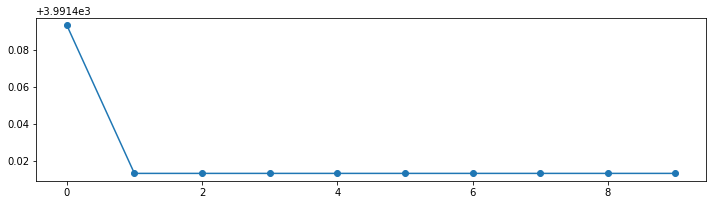

In [142]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(losses, marker='o')
plt.show()

In [143]:
prediction, hidden = model(prepare(['<#S>']), model.init_hidden())

In [144]:
index2word[prediction.argmax().item()]

'biología'

In [151]:
def generate(start='<#S>', max_len=5):
    text = [start]
    for w in range(max_len):
        prediction, hidden = model(prepare([text[-1]]), model.init_hidden())
        next_word = np.random.choice(index2word.keys, p=np.exp(prediction.detach().numpy()[0]))
        text.append(next_word)
        if next_word == '<#E>':
            break
    return text

In [152]:
generate()

ValueError: ignored